In [ ]:
# Initial file for testing RT 
# Has all the code basically copy-pasted from Tine

In [1]:
%%time
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

CPU times: user 653 ms, sys: 300 ms, total: 952 ms
Wall time: 4.86 s


In [2]:
n_H_arr = np.load('outputs/sub_grid/n_H.npy')
n_H2_arr = np.load('outputs/sub_grid/n_H2.npy')
X_H2_arr = np.load('outputs/sub_grid/X_H2.npy')
n_LW_arr = np.load('outputs/sub_grid/n_LW.npy')
n_LW_ss_arr = np.load('outputs/sub_grid/n_LW_ss.npy')
X_H2_ss_arr = np.load('outputs/sub_grid/X_H2_ss.npy')
n_H2_ss_arr = np.load('outputs/sub_grid/n_H2_ss.npy')
X_CO_arr = np.load('outputs/sub_grid/X_CO.npy')
n_CO_arr = np.load('outputs/sub_grid/n_CO.npy')
pdf_arr = np.load('outputs/sub_grid/pdf.npy')
lambda_jeans_arr = np.load('outputs/sub_grid/lambda_jeans.npy')

In [3]:
%%time

#Defining all the constants used in this whole program

m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
mach_no = pynbody.array.SimArray(10., "1")
Z = 0.02/0.02
G_o = 1
n_H_mean = pynbody.array.SimArray(100., "cm**-3")
c = pynbody.array.SimArray(299792458, "m s**-1")
c_cgs = pynbody.array.SimArray(29979245800, "cm s**-1")
h_ev = pynbody.array.SimArray(4.13566770e-15, "eV s")
h_si = pynbody.array.SimArray(6.626e-34, "J s")
grad_v = (np.sqrt(K_b * T_mean/m_p))/(lambda_jeans_arr[0])
T_bg = pynbody.array.SimArray(2.73, "K")
eV = pynbody.array.SimArray(6.241509e18, "J")
#pynbody.array.SimArray(, "")


CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.22 ms


In [4]:
%%time
def get_filename(species):
    # filename is already given
    if (species[-4:] == '.dat') or (species[-4:] == '.txt'):
        return species
    # molecule is chosen
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    database = os.path.join(THIS_FOLDER, 'LAMDA')
    if species == 'HCO+':
        filename = os.path.join(database, 'HCO+.dat')
    elif species == 'H13CO+':
        filename = os.path.join(database, 'H13CO+.dat')
    elif species == 'N2H+':
        filename = os.path.join(database, 'N2H+.dat')
    elif species == 'SiO':
        filename = os.path.join(database, 'SiO.dat')
    elif species == 'HNC':
        filename = os.path.join(database, 'HNC.dat')
    elif species == 'HCN':
        filename = os.path.join(database, 'HCN.dat')
    elif species == 'CO':
        filename = os.path.join(database, 'CO.dat')
    else:
        print('Unknow species. Chose from HCO+, H13CO+, N2H+, SiO, HNC, HCN, CO')
        print('or provide a LAMDA datafile.')
        exit()

    return filename


CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 13.1 µs


In [5]:
def read_file(species):
    filename = get_filename(species)
    f = open(filename, 'r')
    
    f.readline()
    species = f.readline()
    
    f.readline()
    mu = float(f.readline())  # molecular weight
    
    f.readline()
    num_lvls = int(f.readline())  # number of energy levels
    
    # read energy levels: energy E, statistical weight g
    f.readline()
    E = []
    g = []
    for l in range(num_lvls):
        words = f.readline().split()
        E.append(float(words[1]) * c_cgs*h_ev)  # cm^-1 -> eV
        g.append(float(words[2]))
    
    f.readline()
    num_trans = int(f.readline())  # number of radiative transistions
    
    # read transistions: upper lvl, lower lvl, A-coefficient, frequency
    f.readline()
    A = np.zeros((num_lvls, num_lvls))
    freq = np.zeros((num_lvls, num_lvls))
    for t in range(num_trans):
        words = f.readline().split()
        i = int(words[1]) - 1
        j = int(words[2]) - 1
        A[i][j] = float(words[3])  # s^-1
        freq[i][j] = float(words[4]) * 1e9  # GHz -> Hz
        freq[j][i] = freq[i][j]
    
    # compute B-coefficient via Einstein relations
    # Bij = coeff for stimulated emission, Bji = coeff for extinction (j<i)
    B = np.zeros((num_lvls, num_lvls))
    for i in range(0, num_lvls):
        for j in range(0, i):
            if A[i][j] != 0:
                B[i][j] = A[i][j] * (c**2) / \
                    (2*h_ev * (freq[i][j]**3))  # m2/(eV*s)
                B[j][i] = B[i][j] * g[i]/g[j]
    
    # number of collision partners in the data file
    f.readline()
    num_partners = int(f.readline())
    
    C_all = []
    temps_all = []
    for partner in range(num_partners):
        # reference
        f.readline()
        line = f.readline()
        
        # number of collisional transitions
        f.readline()
        num_coll = int(f.readline())
        
        # number of temperatures in the table
        f.readline()
        num_temps = int(f.readline())
        
        # read the temperature values
        f.readline()
        words = f.readline().split()
        temps = np.zeros(num_temps)
        for t in range(num_temps):
            temps[t] = float(words[t])
            temps_all.append(temps)  # K
        
        # read collision coeff data: upper lvl, lower lvl, C-coefficient for each temp
        C = np.zeros((num_temps, num_lvls, num_lvls))
        f.readline()
        for col in range(num_coll):
            words = f.readline().split()
            i = int(words[1]) - 1
            j = int(words[2]) - 1
            for t in range(num_temps):
                C[t][i][j] = float(words[3+t]) * 1.e-6 # cm3/s -> m3/s
        
        # calculate the inverse coefficient via LTE relation
        for i in range(num_lvls):
            for j in range(i):
                for t in range(num_temps):
                    if C[t][i][j] != 0:
                        C[t][j][i] = C[t][i][j] * np.exp(-(E[i]-E[j])/(K_b_ev * temps[t]))*g[i]/g[j]
        
        # add collision partner data to global array
        C_all.append(C)

    f.close()
    C_all = pynbody.array.SimArray(np.array(C_all), "m**3 s**-1")
    temps_all = pynbody.array.SimArray(np.array(temps_all), "K")
    E = pynbody.array.SimArray(np.array(E), "eV")
    g = pynbody.array.SimArray(np.array(g), "1")
    freq = pynbody.array.SimArray(np.array(freq), "s**-1")
    A = pynbody.array.SimArray(np.array(A), "s**-1")
    B = pynbody.array.SimArray(np.array(B), "m**2 eV**-1 s**-1")
    return mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, num_coll

#pynbody.array.SimArray(, "")


''' Load preset abundances and fraction for collision coefficients
    PARAMS:
      species = string with the particle name
    RETURNS:
      comp_fracs = list with the fraction of total collision partner density for each partner
      abundance = overall abundance of the molecule (assume n_mol = abundance*rho everywhere)'''
def load_species_info(species):

    if species == 'HCO+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 1.e-09 # = N_species/N_h2
    elif species == 'H13CO+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 2.e-11
    elif species == 'N2H+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 1.e-10
    elif species == 'SiO': # is seems to be unusually slow
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 7.7e-12
    elif species == 'HNC':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 3.1e-10
    elif species == 'HCN':
        comp_fracs = [1.0, 0.0] # H2 and e
        abundance = 3.1e-11
    elif species == 'CO':
        comp_fracs = [0.66, 0.33] # para H2 and orhto H2
        #abundance = 1.e-4
        abundance = 1.0 # dummy for filenames
    else:
        print 'ERROR: Unsupported species'
        exit()

    return comp_fracs, abundance

In [6]:
mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, n_coll = read_file('CO.txt')

In [7]:
%%time
comp_fractions, abundance = load_species_info('CO')

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 10 µs


In [11]:
C_ij = np.zeros((num_temps, num_lvls, num_lvls))
C_ji = np.zeros((num_temps, num_lvls, num_lvls))
for i in range(num_lvls):
    for j in range(i):
        for t in range(num_temps):
            C_ij[t][i][j] = C_all[0][t][i][j]
            C_ji[t][i][j] = C_all[1][t][i][j]

In [12]:
np.shape(C_ji)

(14, 41, 41)

In [13]:
%%time
def partion_function(T, num_lvls, g, E):
    partition_func = 0.0
    for i in range(0, num_lvls):
        partition_func = partition_func + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return partition_func

def calc_lvl_pops(T, num_lvls, g, E):
    ni = []
    partition_func = partion_function(T, num_lvls, g, E)
    for i in range(0, num_lvls):
        ni.append(g[i]*np.exp(-E[i]/(K_b_ev*T)) / partition_func)
    return np.array(ni), partition_func

CPU times: user 12 µs, sys: 1 µs, total: 13 µs
Wall time: 21.9 µs


In [14]:
%%time
ni, partition_func = calc_lvl_pops(T_mean, num_lvls, g, E)
ni = pynbody.array.SimArray(ni, "1")

CPU times: user 12.9 ms, sys: 516 µs, total: 13.5 ms
Wall time: 10.3 ms


In [15]:
np.sum(ni)

SimArray(1., '1.00e+00')

In [16]:
ni

SimArray([2.52017487e-001, 4.34795086e-001, 2.39667991e-001,
          6.38216272e-002, 8.97709269e-003, 6.90457567e-004,
          2.95393325e-005, 7.09896716e-007, 9.64241750e-009,
          7.43330273e-011, 3.26207207e-013, 8.16734404e-016,
          1.16871166e-018, 9.57186337e-022, 4.49229935e-025,
          1.20936783e-028, 1.86926692e-032, 1.66025033e-036,
          8.47975516e-041, 2.49245900e-045, 4.21896986e-050,
          4.11533610e-055, 2.31481079e-060, 7.51303337e-066,
          1.40798479e-071, 1.52452830e-077, 9.54371962e-084,
          3.45643258e-090, 7.24698794e-097, 8.80259880e-104,
          6.19844692e-111, 2.53207907e-118, 6.00492045e-126,
          8.27362646e-134, 6.62771460e-142, 3.08921640e-150,
          8.38477294e-159, 1.32625363e-167, 1.22355605e-176,
          6.58930346e-186, 2.07319680e-195], '1.00e+00')

In [17]:
%%time
N = n_CO_arr[0]
Ni = ni*N
Ni

CPU times: user 147 µs, sys: 17 µs, total: 164 µs
Wall time: 144 µs


In [18]:
%%time
def B_nu_ev(nu, T):
    if nu==0.:
        return 0.
    else:
        x = h_ev*nu/(K_b_ev*T)
        # units eV*s * Hz3 / (m2/s2) = eV * s3 * Hz3 * m-2 = eV/s/Hz/m2
        return 2.0*h_ev*(nu**3)/(c**2) / (np.exp(x)-1.0)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 19.1 µs


In [19]:
%%time
def for_TE(num_lvls, freq, T_mean):
    intensity_rad_field_TE = np.zeros((num_lvls, num_lvls)) #I_{nu}
    for i in range(num_lvls):
        for j in range(num_lvls):
            if freq[i][j] != 0.0:
                intensity_rad_field_TE[i][j] = B_nu_ev(freq[i][j], T_mean) # eV/m2
                
    return intensity_rad_field_TE

CPU times: user 19 µs, sys: 2 µs, total: 21 µs
Wall time: 20 µs


In [20]:
%%time
intensity_rad_field_TE = pynbody.array.SimArray(for_TE(num_lvls, freq, T_mean), "eV m**-2")
source_func_TE = pynbody.array.SimArray(intensity_rad_field_TE, "eV m**-2")

CPU times: user 74.3 ms, sys: 32.7 ms, total: 107 ms
Wall time: 83.4 ms


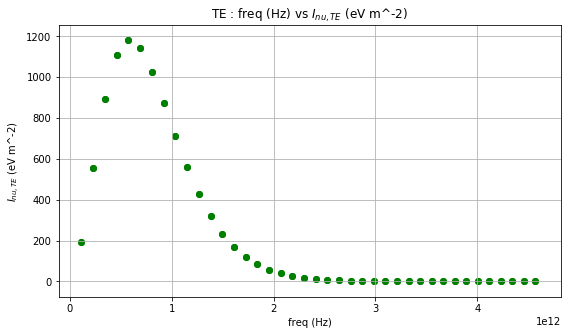

CPU times: user 1.1 s, sys: 70.7 ms, total: 1.17 s
Wall time: 1.33 s


In [21]:
%%time
plt.figure(figsize=(9,5))
for i in range(num_lvls):
        for j in range(num_lvls):
            if freq[i][j] != 0.0:
                plt.scatter(freq[i][j], intensity_rad_field_TE[i][j], color='g')
plt.xlabel('freq (Hz)')
plt.ylabel('$I_{nu, TE}$ (eV m^-2)')
plt.grid(b=True, which='both', axis='both')
plt.title('TE : freq (Hz) vs $I_{nu, TE}$ (eV m^-2)')
plt.savefig('radiative_transfer/outputs_RT/radiative_transfer/TE_freq_vs_Intensity.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [22]:
def calc_emissivity(nu, N_i, A_ij):
    emissivity = h_ev * nu * N_i * A_ij / (4*np.pi)
    return emissivity

def calc_extinction(nu, N_j, B_ji, N_i, B_ij):
    extinction = h_ev * nu * ((N_j*B_ji)-(N_i*B_ij)) / (4*np.pi)
    return extinction

In [23]:
def LTE_solver(num_lvls, rad_field_ini, freq, B_nu, tau):
    I_nu = np.zeros((num_lvls, num_lvls))
    rad_field = rad_field_ini
    I_nu = (B_nu*tau) + (rad_field*np.exp(-tau))
                
    return I_nu

# Optical depth in LVG approximation for line ij
def tau_LVG(Ni, grad_v, n_i, n_j, B_ij, B_ji):
    # units: m/s * eV*s * 1/m3 * m2/(eV*s) / (1/s) = none
    return (c*h_ev/(4.*np.pi)) * Ni * (n_j*B_ji - n_i*B_ij)  / (1.064*grad_v)

# Escape probability in LVG approximation for line ij
def beta_LVG(tau):
    if tau < 0.01:
        return 1. - tau/2.
    elif tau > 100.:
        return 1./tau
    else:
        return (1.0 - np.exp(-tau)) / tau


def for_LTE(num_lvls, T_mean, A, B, C):
    source_func_LTE = np.zeros((num_lvls, num_lvls))
    emissivity = np.zeros((num_lvls, num_lvls))
    extinction = np.zeros((num_lvls, num_lvls))
    intensity_rad_field_bg = np.zeros((num_lvls, num_lvls))
    intensity_rad_field_LTE = np.zeros((num_lvls, num_lvls))
    tau = np.zeros((num_lvls, num_lvls))
    beta = np.zeros((num_lvls, num_lvls))
    
    density = 1.0 #arbitrary
    loop_times = num_lvls
    for i in range(loop_times):
        for j in range(loop_times):
            if freq[i][j] != 0.0:
                source_func_LTE[i][j] = B_nu_ev(freq[i][j], T_mean) # eV/m2
                emissivity[i][j] = calc_emissivity(freq[i][j], Ni[i], A[i][j])
                extinction[i][j] = calc_extinction(freq[i][j], Ni[j], B[j][i], Ni[i], B[i][j])
                tau[i][j] = tau_LVG(Ni[i], grad_v, ni[i], ni[j], B[i][j], B[j][i])
                beta[i][j] = beta_LVG(tau[i][j])
                intensity_rad_field_bg[i][j] = B_nu_ev(freq[i][j], T_bg)
                #intensity_rad_field_LTE or I_{nu, LTE} will be calculated by solving the RTE
                intensity_rad_field_LTE[i][j] = LTE_solver(num_lvls, intensity_rad_field_bg[i][j], freq[i][j], source_func_LTE[i][j], tau[i][j])

    
    return intensity_rad_field_LTE, intensity_rad_field_bg, source_func_LTE, emissivity, extinction, tau, beta




In [25]:
intensity_rad_field_LTE, intensity_rad_field_bg, source_func_LTE, emissivity, extinction, tau, beta = for_LTE(num_lvls, T_mean, A, B, C_all)
source_func_LTE = pynbody.array.SimArray(source_func_LTE, "eV m**-2")



/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


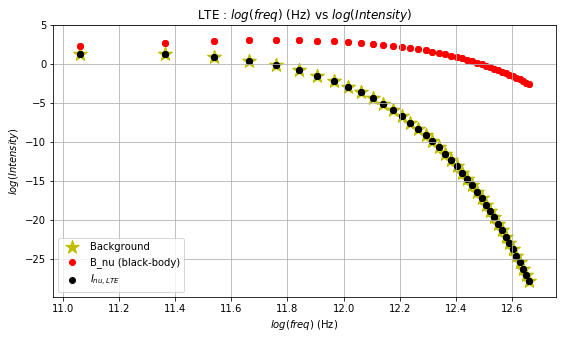

CPU times: user 915 ms, sys: 27.6 ms, total: 943 ms
Wall time: 939 ms


In [26]:
%%time
plt.figure(figsize=(9,5))
# for i in range(num_lvls):
#         for j in range(num_lvls):
#             if freq[i][j] != 0.0:
plt.scatter(np.log10(freq), np.log10(intensity_rad_field_bg), c='y', marker='*', s=200, 
            label='Background')
plt.scatter(np.log10(freq), np.log10(source_func_LTE), c='r',
           label='B_nu (black-body)')
plt.scatter(np.log10(freq), np.log10(intensity_rad_field_LTE), c='k',
           label='$I_{nu, LTE}$')
#plt.scatter(freq[i][j], foo[i][j], c='y')
    
plt.xlabel('$log(freq)$ (Hz)')
plt.ylabel('$log(Intensity)$')
plt.grid(b=True, which='both', axis='both')
plt.legend()
plt.title('LTE : $log(freq)$ (Hz) vs $log(Intensity)$')
plt.savefig('radiative_transfer/outputs_RT/radiative_transfer/LTE_log(freq)_vs_log(Intensity)-compare.png', 
            dpi=300, bbox_inches='tight')
plt.show()

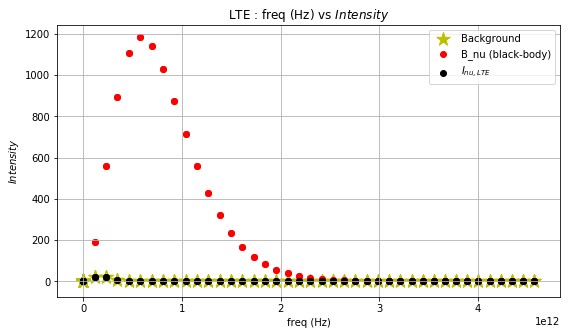

CPU times: user 985 ms, sys: 14.8 ms, total: 999 ms
Wall time: 996 ms


In [27]:
%%time
plt.figure(figsize=(9,5))
# for i in range(num_lvls):
#         for j in range(num_lvls):
#             if freq[i][j] != 0.0:
plt.scatter(freq, intensity_rad_field_bg, c='y', marker='*', s=200, 
            label='Background')
plt.scatter(freq, source_func_LTE, c='r',
           label='B_nu (black-body)')
plt.scatter(freq, intensity_rad_field_LTE, c='k',
           label='$I_{nu, LTE}$')
#plt.scatter(freq[i][j], foo[i][j], c='y')
    
plt.xlabel('freq (Hz)')
plt.ylabel('$Intensity$')
plt.grid(b=True, which='both', axis='both')
plt.legend()
plt.title('LTE : freq (Hz) vs $Intensity$')
plt.savefig('radiative_transfer/outputs_RT/radiative_transfer/LTE_freq_vs_Intensity-compare.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [28]:
''' Calculate net collision coeff for a gas consisting of different components at temp T
    Interpolates table betweem T values
    PARAMS:
      T = temperature (K)
      comp_fractions = fraction of the total density in each component 
    RETRUN:
      C = netto collision coeff C[i][j] (m3/s) '''
def calc_total_C(T, comp_fractions):
    C = np.zeros((num_lvls,num_lvls))
    for p in range(num_partners):
        max_index = len(temps_all[p])
        if T <= temps_all[p][0]: # T is lower than lowest value in table
            for i in range(num_lvls):
                for j in range(num_lvls):
                    C[i][j] = C[i][j] + comp_fractions[p] * C_all[p][0][i][j]
        elif T >= temps_all[p][max_index-1]: # T is higher than highest value in table
            for i in range(num_lvls):
                for j in range(num_lvls):
                    C[i][j] = C[i][j] + comp_fractions[p] * C_all[p][max_index-1][i][j]
        else: # determine temperature entries needed to interpolate
            t = 1 # T index of upper limit
            while temps_all[p][t] < T:
                t = t+1
            t_frac = (temps_all[p][t] - T)/(temps_all[p][t] - temps_all[p][t-1])
            for i in range(num_lvls):
                for j in range(num_lvls):
                    interpol = (1-t_frac) * C_all[p][t][i][j] + \
                                   t_frac * C_all[p][t-1][i][j]
                    C[i][j] = C[i][j] + comp_fractions[p] * interpol
                    
    return C
    
    
''' Full non-LTE, with radiation field:
    Calculate non-LTE occupation numbers by solving the system of coupled balance equations
    PARAMS:
      num_lvls = number of energy levels
      A = Einstein A coeff matrix (1/s)
      B = Einstein B coeff matrix (m2/(eV*s))
      C = netto collision coeff matrix (m3/s)
      n_coll = total number density of collision partners (1/m3)
      rad_field = incomming radiation field for each transition I[i][j] (eV/s/m2/Hz = eV/m2)
    RETURN:
      sol = level populations '''
def calc_lvlpops_nonLTE(num_lvls, A, B, C, n_coll, rad_field):
    # solve  M*n = 0
    # n = [n1,n2,...ni,...,nn]

    # fill matrix M
    M = np.zeros((num_lvls,num_lvls))
    for a in range(0, num_lvls):
        for b in range(0,num_lvls):
            M_ab = 0
            # upper triangle
            if b>a:
                M_ab = A[b][a] + B[b][a]*rad_field[b][a] + C[b][a]*n_coll #1/s
            # diagonal
            elif a==b:
                for j in range(0, a):
                    M_ab = M_ab - A[a][j] - (B[a][j]*rad_field[a][j]) - C[a][j]*n_coll
                for j in range(a+1, num_lvls):
                    M_ab = M_ab - B[a][j]*rad_field[j][a] - C[a][j]*n_coll
            # lower triangle
            else:
                M_ab = B[b][a]*rad_field[a][b] + C[b][a]*n_coll
            M[a][b] = M_ab

    # solve M*n=0 with svd: M = U*S*V.T
    U, S, Vt = np.linalg.svd(M)
    # In S the smallest singular value is given last. Check if it sufficiently small
    if S[num_lvls-1] > 1.0e-4*S[num_lvls-2]:
        print 'WARNING: unreliable solution:', S 
    sol = Vt[num_lvls-1]

    # sol can be multiplied by a constant factor: normalise to sum(sol_i) = 1
    # (assumes all values are either positive or neg)
    norm=np.sum(sol)
    sol=sol/norm
    return sol

''' total emissivity of transition i-j in W/m3/sr
    J = integral j dv = integral cst phi(v) dv = cst integral phi dv = cst * 1
    Remark that v_ij is constant! '''
def integrated_emissivity(nu_ij, x_i, n_molec, A_ij):
    # units: J*s * Hz * sr-1 * m-3 * s-1 = J/s/m3/sr
    return h_si*nu_ij/(4*np.pi) * x_i * n_molec * A_ij 


''' total extinction of transition i-j in 1/m/sr/s
    B in m2/(eV*s) '''
def integrated_extinction(nu_ij, x_i, x_j, n_molec, B_ij, B_ji):
    # units: eV*s * Hz * sr-1 * m2/(eV*s) * m-3 = 1/m/sr/s
    return h_ev*nu_ij/(4*np.pi) * (x_j*B_ji - x_i*B_ij) * n_molec


''' Source function of transision i-j for optically thick media S=j/a in eV/s/Hz/m2 '''
def source_function_thick(nu_ij, x_i, x_j, n_molec, A_ij, B_ij, B_ji):
    j = integrated_emissivity(nu_ij, x_i, n_molec, A_ij) / eV
    a = integrated_extinction(nu_ij, x_i, x_j, n_molec, B_ij, B_ji)
    # units: (eV/s/m3/sr) / (1/m/sr/s) = eV/m2 = eV/s/Hz/m2
    return j/a


''' Self-consistently solve for the level populations with the general method
    in the optical thick limit!
    PARAMS:
      line_data = lineData object with info about the transitions
      n_coll = total number density of collision partners (1/m3)
      comp_fractions = fractions of n_coll for each collision partner (from species file)
      n_molec = number density of the molecule (1/m3)
      T = temperature (K)
      rad_field_bg =  background radiation field (CMB)
      num_iter = number of iterations for determining the lvl pops'''
def solve_lvlpops_nonLTE(n_coll, comp_fractions, n_molec, T, rad_field_bg, num_iter=10):

    # calc netto collision coeffs
    C = calc_total_C(T, comp_fractions)

    # set initial radiation field
    source = np.zeros((num_lvls,num_lvls))
    #J = emis * 4.*np.pi #* dx # eV/m2
    J = rad_field_bg

    for it in range(num_iter):
        lvl_pops = calc_lvlpops_nonLTE(num_lvls, A, B, C, n_coll, J)
        # calculate the emissivity
        for i in range(num_lvls):
            for j in range(i):
                if freq[i][j] != 0.:
                    source[i][j] = source_function_thick(freq[i][j],
                                             lvl_pops[i], lvl_pops[j],
                                             n_molec, A[i][j],
                                             B[i][j], B[j][i])
        J = source
        #J = J + rad_field_bg

    return lvl_pops

In [29]:
lvl_pops_non_LTE = solve_lvlpops_nonLTE(n_coll, comp_fractions, n_CO_arr[0], T_mean, intensity_rad_field_bg, 10)

In [30]:
lvl_pops_non_LTE

array([ 9.99998848e-01,  1.10682573e-06,  4.51112824e-08,  5.28822560e-10,
        1.97895939e-11,  2.18752323e-13,  2.17651594e-15,  5.97660964e-18,
        2.20844543e-20, -1.38292105e-20, -9.87197574e-21, -6.65602799e-21,
       -4.88459848e-21, -4.79741770e-21, -4.74106365e-21, -3.73821808e-21,
       -3.25993266e-21, -2.19362393e-21, -1.88043931e-21, -2.20618939e-21,
       -1.33745209e-21, -1.49212592e-21, -1.34655216e-21, -1.06983468e-21,
       -9.21882655e-22, -5.65289247e-22, -5.78032336e-22, -5.80513498e-22,
       -3.25578471e-22, -3.02370632e-22, -4.05623971e-22, -2.66212264e-22,
       -3.28319634e-22, -1.59945521e-22, -1.87915366e-22, -7.79586573e-23,
       -5.77601244e-23, -1.27285478e-22, -9.15592851e-23, -1.27679683e-22,
        5.21425146e-24])

In [31]:
np.shape(lvl_pops_non_LTE)

(41,)

In [32]:
#-------LVG solver----------------------------------------------------------------------------------
""" LVG + EscProb method 
    Calculate non-LTE occupation numbers by solving the system of coupled balance equations with
    the LVG approximation
    PARAMS:
      num_lvls = number of energy levels
      A = Einstein A coeff matrix (1/s)
      B = Einstein B coeff matrix (m2/(eV*s))
      C = netto collision coeff matrix (m3/s)
      n_coll = total number density of collision partners (1/m3)
      rad_field_bg = background radiation field for each transition I[i][j] (eV/s/m2/Hz = eV/m2)
      beta =  escape probability for each transition (/)
    RETURN:
      sol = level populations"""
def calc_lvlpops_LVG(num_lvls, A, B, C, n_coll, rad_field_bg, beta):
    # solve  M*n = 0
    # n = [n1,n2,...ni,...,nn]

    # fill matrix M
    M = np.zeros((num_lvls,num_lvls))
    for a in range(0, num_lvls):
        for b in range(0,num_lvls):
            M_ab = 0
            # upper triangle
            if b>a:
                M_ab = A[b][a]*beta[b][a] + B[b][a]*rad_field_bg[b][a]*beta[b][a] + C[b][a]*n_coll
            # diagonal
            elif a==b:
                for j in range(0, a):
                    M_ab = M_ab - A[a][j]*beta[a][j] - B[a][j]*rad_field_bg[a][j]*beta[a][j]\
                           - C[a][j]*n_coll
                for j in range(a+1, num_lvls):
                    M_ab = M_ab - B[a][j]*rad_field_bg[j][a]*beta[j][a] - C[a][j]*n_coll
            # lower triangle
            else:
                M_ab = B[b][a]*rad_field_bg[a][b]*beta[a][b] + C[b][a]*n_coll
            M[a][b] = M_ab

    # solve M*n=0 with svd: M = U*S*V.T
    U, S, Vt = np.linalg.svd(M)
    # In S the smallest singular value is given last. Check if it sufficiently small
    if S[num_lvls-1] > 1.0e-4*S[num_lvls-2]:
        print 'WARNING: unreliable solution', S
    sol = Vt[num_lvls-1]

    # sol can be multiplied by a constant factor: normalise to sum(sol_i) = 1
    # (assumes all values are either positive or neg)
    norm=np.sum(sol)
    sol=sol/norm
    return sol

#---------------------------------------------------------------------------------------------------
''' calculate the partition function
    PARAMS:
      T = temperature (K)
      num_lvls = number of energy levels
      g = statistical weight of each level
      E = energy of each level (eV)'''
def partion_function(T, num_lvls, g, E):
    Z=0.0
    for i in range(0,num_lvls):
        Z = Z + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return Z

''' calculate LTE occupation numbers with partition function method
    PARAMS:
      T = temperature (K)
      num_lvls = number of energy levels
      g = statistical weight of each level
      E = energy of each level (eV)
    RETURN:
      ni = level populations '''
def calc_lvlpops_partion(T, num_lvls, g, E):
    ni = []
    Z = partion_function(T, num_lvls, g, E)
    for i in range(0, num_lvls):
        ni.append(g[i]*np.exp(-E[i]/(K_b_ev*T)) / Z)
    return ni

''' Self-consistently solve for the level populations with LVG approximation 
    PARAMS:
      line_data = lineData object with info about the transitions
      n_coll = total number density of collision partners (1/m3)
      comp_fracs = fractions of n_coll for each collision partner
      n_molec = number density of the molecule (1/m3)
      T = temperature (K)
      grad_v = velocity gradient (s-1)
      rad_field_bg =  background radiation field (CMB)
      num_iter = maximum number of iterations for determining the lvl pops'''
def solve_lvlpops_LVG(n_coll, comp_fracs, n_molec, T, grad_v, rad_field_bg, num_iter):
    # calc netto collision coeffs
    C = calc_total_C(T, comp_fracs)

    # initialize x_i to LTE
    lvl_pops = calc_lvlpops_partion(T, num_lvls, g, E)

    # calculate tau and beta for LVG
    tau, beta = LVG_coeffs_all_lines(n_molec, lvl_pops, B, grad_v)
    T_ex_prev = 0.0
    T_ex_curr = calc_T_ex(1, 0, lvl_pops, g, E)
    it=0
    convergence = abs(T_ex_curr-T_ex_prev)/(T_ex_curr+T_ex_prev)/2.

    # update level pops with LVG and iterate
    while (convergence>0.01) and (it<num_iter):
        it=it+1
        lvl_pops = calc_lvlpops_LVG(num_lvls, A, B, C, n_coll, rad_field_bg, beta)
        tau, beta = LVG_coeffs_all_lines(n_molec, lvl_pops, B, grad_v)
        T_ex_prev = T_ex_curr
        T_ex_curr = calc_T_ex(1, 0, lvl_pops, g, E)
        convergence = abs(T_ex_curr-T_ex_prev)/(T_ex_curr+T_ex_prev)/2.
        #print 'iteration {} -> convergence {:1.3}%'.format(it, convergence)

    return lvl_pops, beta

''' Calculate tau and beta in LVG approx for all lines
    PARAMS:
      n_molec = number density of the molecule (1/m3)
      lvl_pops = level populations
      B = Einstein B coeff matrix (m2/(eV*s))
      grad_v = velocity gradient (1/s) '''
def LVG_coeffs_all_lines(n_molec, lvl_pops, B, grad_v):
    ni, nj = B.shape
    tau = np.ones((ni,nj))
    beta = np.ones((ni,nj))
    for i in range(ni):
        for j in range(i):
            if B[i][j]==0:
                tau[i][j] = 1.0 # arbitrary
                beta[i][j] = 1.0 #0.0
            else:
                tau[i][j] = tau_LVG(n_molec, grad_v, lvl_pops[i], lvl_pops[j], B[i][j], B[j][i])
                beta[i][j] = beta_LVG(tau[i][j])
                #print 'i {} j {} tau={} beta={}'.format(i,j,tau[i][j],beta[i][j]) 
    return tau, beta

''' Optical depth in LVG approximation for line ij '''
def tau_LVG(n_molec, grad_v, x_i, x_j, B_ij, B_ji):
    # units: m/s * eV*s * 1/m3 * m2/(eV*s) / (1/s) = none
    return c*h_ev/(4.*np.pi) * n_molec * (x_j*B_ji - x_i*B_ij)  / (1.064*grad_v)

''' Escape probability in LVG approximation for line ij
    PARAMS:
      tau = optical depth'''
def beta_LVG(tau):
    if tau < 0.01:
        return 1. - tau/2.
    elif tau > 100.:
        return 1./tau
    else:
        return (1.0 - np.exp(-tau)) / tau

''' Determine the density for which tau LVG is 1 using B coeffs '''
def critical_density_B(grad_v, x_i, x_j, B_ij, B_ji, abundance):
    n_molec_crit = (4.*np.pi*1.064*grad_v)/((x_j*B_ji - x_i*B_ij)*c*h)
    print 'n_crit', n_molec_crit/ 1e6 / abundance, 'H2/cc'
    return n_molec_crit / abundance * (2*MH) # kg/m3

''' Determine the density for which tau LVG is 1 using A coeff '''
def critical_density_A(grad_v, x_i, x_j, A_ij, freq, g_i, g_j, abundance):
    n_molec_crit = (8.*np.pi*(freq**3)*1.064*grad_v)/((x_j*(g_i/g_j) - x_i)*A_ij*(c**3))
    print 'n_crit', n_molec_crit/ 1e6 / abundance, 'H2/cc'
    print 'args rho_crit:', grad_v, x_i, x_j, A_ij, freq, g_i, g_j, abundance
    return n_molec_crit / abundance * (2*MH) # kg/m3

''' TODO Estimate the critical density in function of grad_v in the simulation '''

#---------------------------------------------------------------------------------------------------
''' Calculate the excitation temperature. This is the LTE temperature corresponding to the given x_i
    PARAMS:
      u = number of the upper energy level (0=ground state)
      d = number of the lower energy level
      x = array of occupation numbers
      g = weights of all levels
      E = energy of all levels (eV) '''
def calc_T_ex(u, d, x, g, E):
    if x[u]==0.:
        return 0.0
    elif x[d]==0.:
        return 0.0 #should be inf but this is annoying to plot
    else:
        return -(E[u]-E[d])/(K_b_ev * np.log(x[u]*g[d]/(x[d]*g[u])))

    
def lvlpops_core_func(n_H2_arr, comp_fracs, n_CO_arr, T_mean, 
                                            grad_v, intensity_rad_field_bg, num_iter):
    lvl_pops = np.zeros((num_lvls))
    lvl_pops, beta_cell = solve_lvlpops_LVG(n_H2_arr[0], comp_fracs, n_CO_arr[0], T_mean, 
                                            grad_v, intensity_rad_field_bg, num_iter)
    return lvl_pops, beta_cell

In [34]:
lvl_pops_LVG, beta_cell = lvlpops_core_func(n_H2_arr, comp_fractions, n_CO_arr, T_mean, 
                                            grad_v, intensity_rad_field_bg, 10)

In [35]:
lvl_pops_LVG

array([ 7.10797736e-01,  2.81039443e-01,  8.13672460e-03,  2.60862771e-05,
        1.01272766e-08,  4.91898691e-13, -8.98041365e-16, -7.64898807e-16,
       -7.42500442e-16, -6.71642040e-16, -1.15191770e-15, -3.20710642e-16,
       -2.25677242e-16, -5.43253945e-18, -4.03741804e-17,  1.13833546e-16,
        8.13315995e-17,  2.54294945e-16,  2.07066076e-16,  1.98321687e-16,
        1.80830950e-16,  1.61956968e-16,  1.23897602e-16,  1.54226883e-16,
        1.01523273e-16,  1.42313126e-16,  5.65136399e-17,  7.03726573e-17,
        7.62263555e-17,  1.21935654e-16,  1.03351074e-16,  9.63317056e-17,
        1.08984860e-16,  7.25416281e-17,  6.78551950e-17,  8.14454379e-17,
        7.85414231e-17,  7.39820508e-17,  4.86438799e-17,  1.95920585e-17,
        3.07566135e-18])